In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn gradio plotly

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import gradio as gr
import plotly.express as px

df = pd.read_csv('processed_microplastics.csv')
df.head()

,year,country,cheese,yoghurt,total_milk,fruits,refined_grains,whole_grains,nuts_and_seeds,total_processed_meats,...,fish,shellfish,eggs,total_salt,added_sugars,non-starchy_vegetables,potatoes,other_starchy_vegetables,beans_and_legumes,total_ug_per_kg
0,1990,Angola,0.191781,54.899739,96.602740,76.520548,481.297149,44.309838,2.849315,22.770109,...,53.013699,0.164384,1.041096,8.005259,32.547945,80.164384,8.109589,39.342466,19.835616,1043.279108
1,1990,Benin,0.054795,9.365946,18.410959,90.876712,534.256965,48.836323,19.561644,17.018264,...,18.794521,3.972603,2.849315,5.854497,8.246575,122.986301,0.000000,304.904110,21.178082,1241.656197
2,1990,Burkina Faso,0.273973,35.390618,56.027397,19.178082,213.170183,129.416119,28.465753,9.541329,...,4.684932,0.000000,6.767123,6.928378,9.534247,64.767123,2.219178,13.780822,32.520548,666.603927
3,1990,Central African Republic,0.000000,19.206478,48.000000,113.397260,285.035375,302.567776,23.506849,26.412094,...,13.917808,0.000000,1.123288,6.585071,19.698630,101.753425,0.575342,209.452055,12.821918,1237.339905
4,1990,Cote D'Ivoire,0.301370,2.220447,38.109589,37.013699,436.907598,25.220347,16.904110,2.459103,...,51.424658,0.493151,2.438356,9.660915,28.438356,151.150685,1.945205,676.575343,2.356164,1540.502458



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 723 entries, 0 to 722
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   year                      723 non-null    int64  
 1   country                   723 non-null    object 
 2   cheese                    723 non-null    float64
 3   yoghurt                   723 non-null    float64
 4   total_milk                723 non-null    float64
 5   fruits                    723 non-null    float64
 6   refined_grains            723 non-null    float64
 7   whole_grains              723 non-null    float64
 8   nuts_and_seeds            723 non-null    float64
 9   total_processed_meats     723 non-null    float64
 10  unprocessed_red_meats     723 non-null    float64
 11  fish                      723 non-null    float64
 12  shellfish                 723 non-null    float64
 13  eggs                      723 non-null    float64


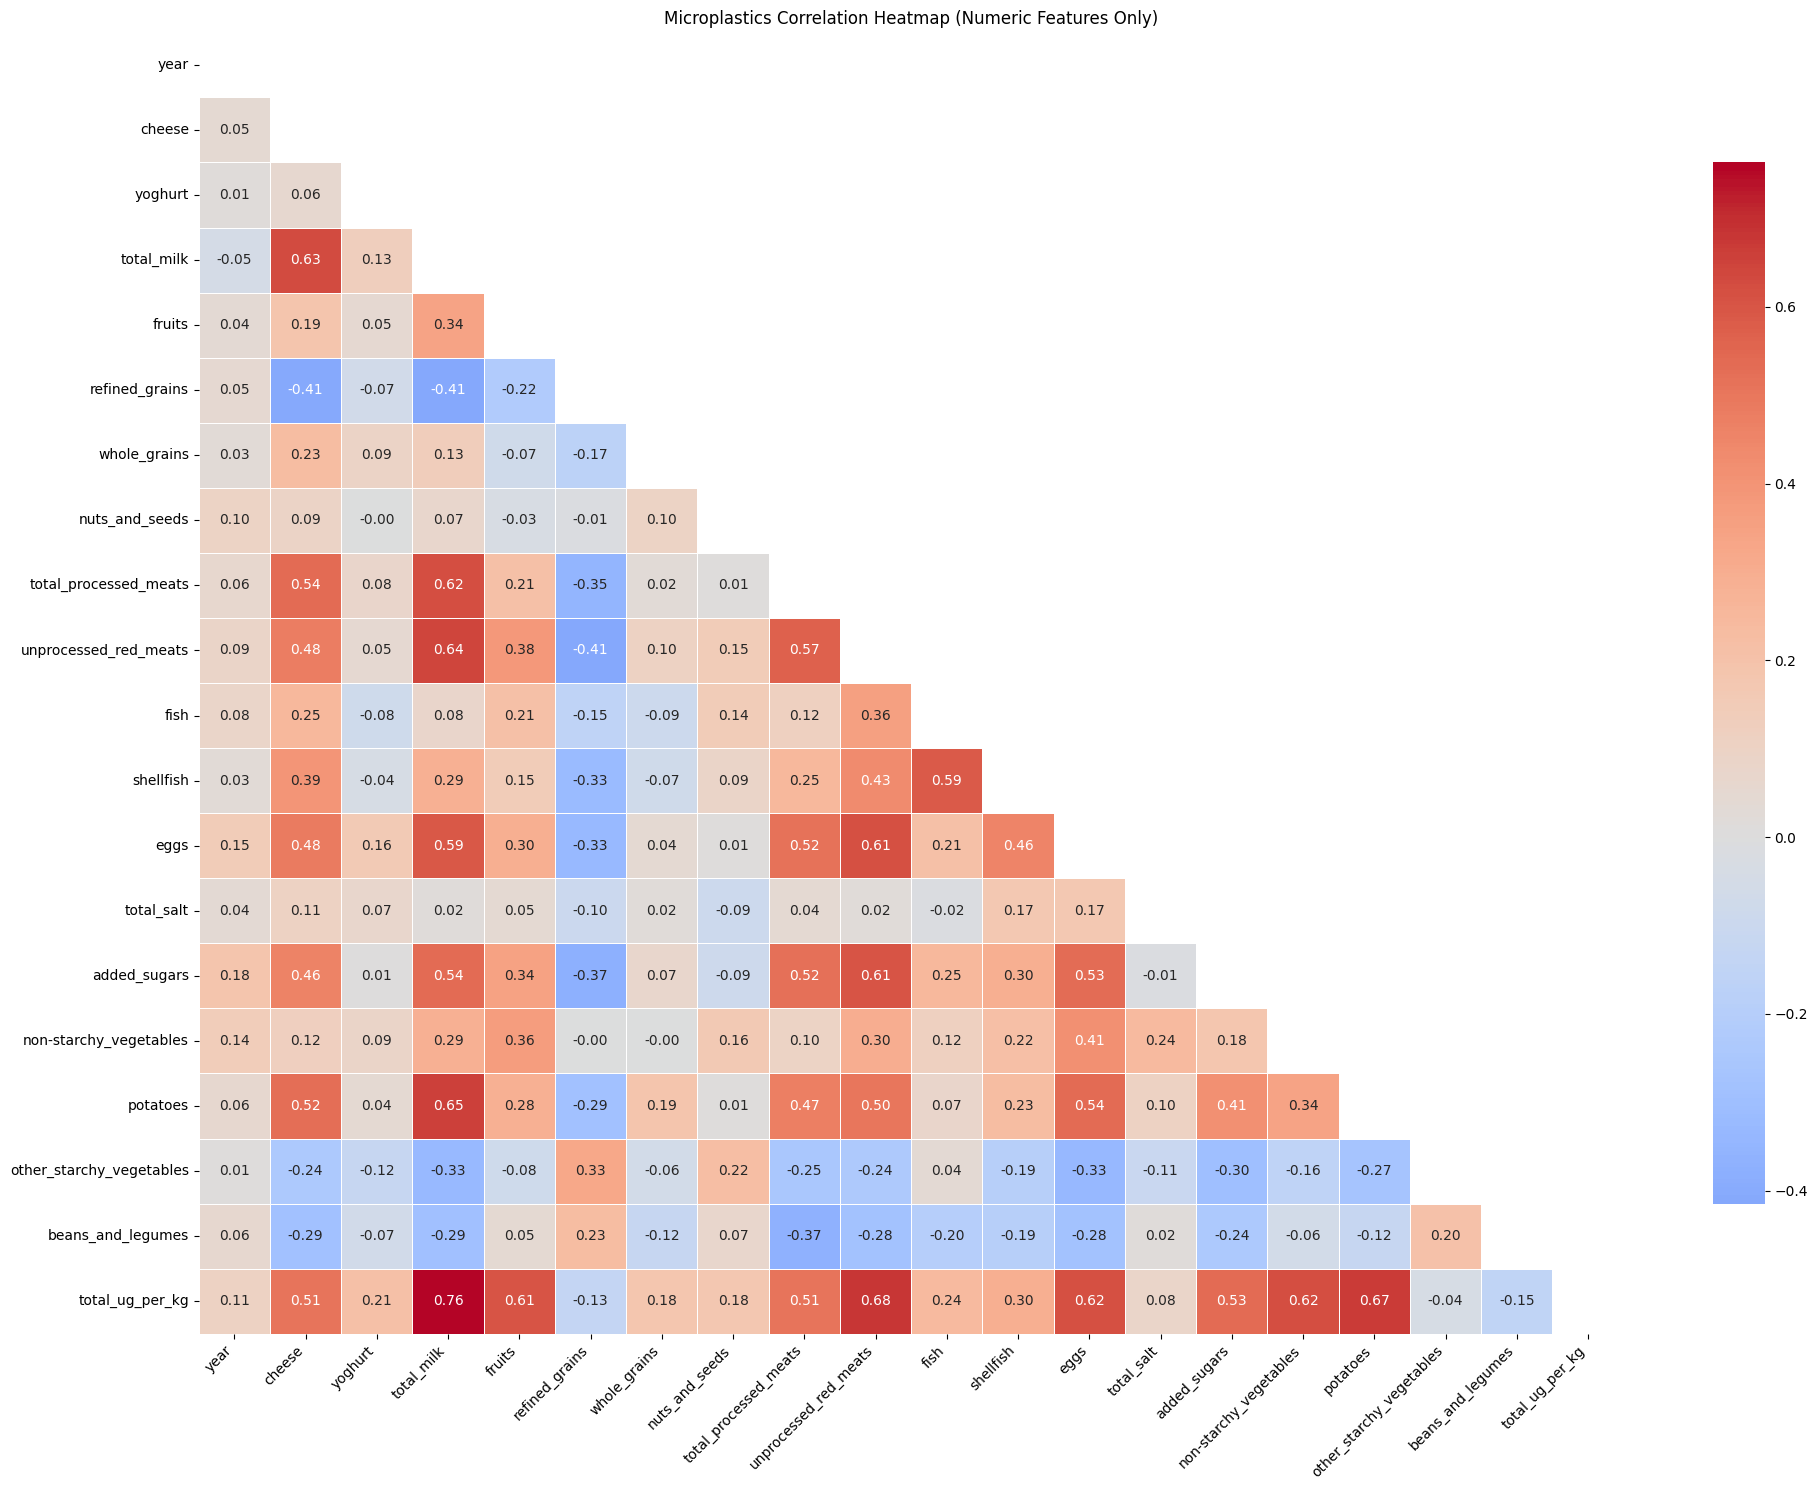

In [5]:
print("\nDataset Info:")
print(df.info())

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("\nNumeric columns for correlation analysis:")
print(numeric_cols)

plt.figure(figsize=(20, 15))
try:
    corr = df[numeric_cols].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', center=0,
                fmt=".2f", linewidths=.5, cbar_kws={"shrink": .8})
    plt.title('Microplastics Correlation Heatmap (Numeric Features Only)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error creating correlation heatmap: {e}")

try:
    fig = px.line(df, x='year', y='total_ug_per_kg', color='country',
                  title='Total Microplastics Over Time by Country',
                  labels={'total_ug_per_kg': 'Microplastics (μg/kg)'},
                  height=600)
    fig.update_layout(xaxis_title='Year', yaxis_title='Microplastics (μg/kg)')
    fig.show()
except Exception as e:
    print(f"Error creating time series plot: {e}")


In [6]:
features = [col for col in numeric_cols if col not in ['year', 'total_ug_per_kg']]
target = 'total_ug_per_kg'

print("\nFeatures used for modeling:")
print(features)

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'\nModel MSE: {mse:.2f}')


Features used for modeling:
['cheese', 'yoghurt', 'total_milk', 'fruits', 'refined_grains', 'whole_grains', 'nuts_and_seeds', 'total_processed_meats', 'unprocessed_red_meats', 'fish', 'shellfish', 'eggs', 'total_salt', 'added_sugars', 'non-starchy_vegetables', 'potatoes', 'other_starchy_vegetables', 'beans_and_legumes']

Model MSE: 17284.72


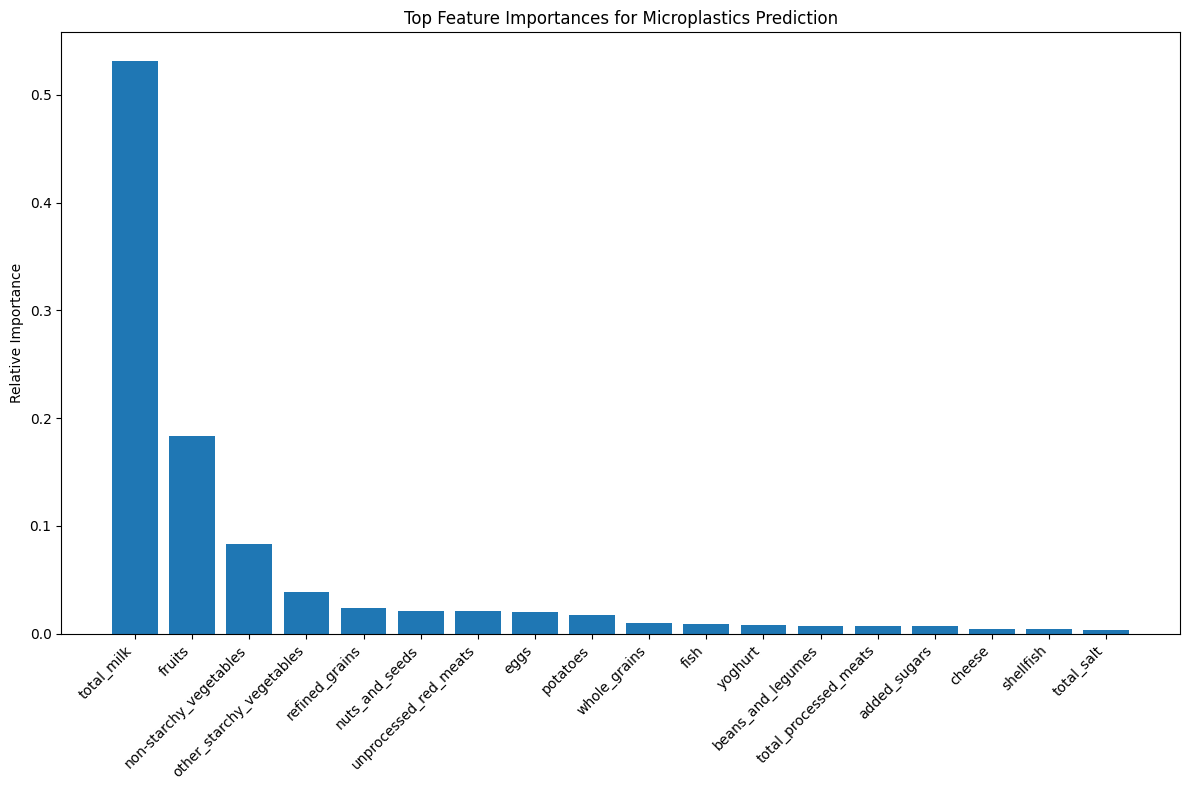

In [10]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title('Top Feature Importances for Microplastics Prediction')
plt.bar(range(18), importances[indices][:18], align='center')
plt.xticks(range(18), [features[i] for i in indices[:18]], rotation=45, ha='right')
plt.ylabel('Relative Importance')
plt.tight_layout()
plt.show()

In [14]:
def create_gradio_interface(df, model):

    countries = sorted(df['country'].unique().tolist())

    intro_markdown = """
    # Microplastics in Food Consumption Analysis

    ## Project Overview
    This project analyzes microplastic contamination levels in various food categories across different countries and years.

    ### Key Features:
    - **Prediction Tool**: Estimate total microplastics based on food consumption patterns
    - **Country Trends**: Visualize microplastic trends over time for specific countries
    - **Food Analysis**: Compare microplastic levels across different food categories

    *Data Source: Processed microplastics measurements from global food surveys*
    """

    def predict_microplastics(cheese, yoghurt, total_milk, fruits, refined_grains,
                            whole_grains, nuts_and_seeds, processed_meats,
                            unprocessed_meats, fish, shellfish, eggs, salt,
                            added_sugars, non_starchy_veg, potatoes, other_starchy_veg,
                            beans_legumes):
        input_data = [[cheese, yoghurt, total_milk, fruits, refined_grains,
                      whole_grains, nuts_and_seeds, processed_meats,
                      unprocessed_meats, fish, shellfish, eggs, salt,
                      added_sugars, non_starchy_veg, potatoes, other_starchy_veg,
                      beans_legumes]]
        prediction = model.predict(input_data)[0]
        return f"Predicted Microplastics: {prediction:.2f} μg/kg"

    def plot_country_trend(country):
        country_data = df[df['country'] == country]
        fig = px.line(country_data, x='year', y='total_ug_per_kg',
                      title=f'Microplastics Trend for {country} (1990-2005)',
                      labels={'total_ug_per_kg': 'Microplastics (μg/kg)'},
                      color_discrete_sequence=['#4285F4'])
        fig.update_layout(
            xaxis_title='Year',
            yaxis_title='Microplastics (μg/kg)',
            plot_bgcolor='rgba(0,0,0,0)',
            paper_bgcolor='rgba(0,0,0,0)'
        )
        return fig

    def plot_food_heatmap(year):
        year_data = df[df['year'] == year]
        food_cols = ['cheese', 'yoghurt', 'total_milk', 'fruits', 'refined_grains',
                    'whole_grains', 'nuts_and_seeds', 'total_processed_meats',
                    'unprocessed_red_meats', 'fish', 'shellfish', 'eggs']
        heatmap_data = year_data[food_cols].mean().reset_index()
        heatmap_data.columns = ['Food', 'Microplastics']
        fig = px.bar(heatmap_data, x='Food', y='Microplastics',
                     title=f'Average Microplastics by Food Type ({year})',
                     labels={'Microplastics': 'Microplastics (μg/kg)'},
                     color='Microplastics',
                     color_continuous_scale='Viridis')
        fig.update_layout(
            xaxis_title='Food Type',
            yaxis_title='Microplastics (μg/kg)',
            xaxis_tickangle=-45
        )
        return fig

    with gr.Blocks(title="Microplastics Analysis", theme=gr.themes.Soft()) as demo:

        gr.Markdown(intro_markdown)

        gr.Markdown("---")


        with gr.Tabs():
            with gr.Tab("Dashboard"):
                gr.Markdown("## Global Microplastics Overview")

                with gr.Row():
                    with gr.Column():
                        gr.Markdown("### Select a country to view trends")
                        country_dropdown = gr.Dropdown(
                            choices=countries,
                            label="Country",
                            value="United States"
                        )
                        country_plot = gr.Plot()

                    with gr.Column():
                        gr.Markdown("### Select a year to view food analysis")
                        year_dropdown = gr.Dropdown(
                            choices=sorted(df['year'].unique().tolist()),
                            label="Year",
                            value=2005
                        )
                        food_plot = gr.Plot()

                country_dropdown.change(plot_country_trend, inputs=country_dropdown, outputs=country_plot)
                year_dropdown.change(plot_food_heatmap, inputs=year_dropdown, outputs=food_plot)


                with gr.Row():
                    with gr.Column():
                        gr.Markdown("### Countries with Highest Contamination")
                        top_countries = df.groupby('country')['total_ug_per_kg'].mean().nlargest(5)
                        gr.Dataframe(
                            value=top_countries.reset_index().rename(columns={
                                'total_ug_per_kg': 'Avg Microplastics (μg/kg)'
                            }),
                            interactive=False
                        )

                    with gr.Column():
                        gr.Markdown("### Foods with Highest Contamination")
                        food_cols = [col for col in df.columns if col not in ['country', 'year', 'total_ug_per_kg']]
                        avg_food = df[food_cols].mean().nlargest(5)
                        gr.Dataframe(
                            value=avg_food.reset_index().rename(columns={
                                'index': 'Food',
                                0: 'Avg Microplastics (μg/kg)'
                            }),
                            interactive=False
                        )

            with gr.Tab("Prediction Tool"):
                gr.Markdown("## Microplastics Prediction Tool")
                gr.Markdown("Adjust the sliders to estimate total microplastic contamination based on food consumption patterns.")

                with gr.Row():
                    with gr.Column():
                        gr.Markdown("### Dairy & Grains")
                        cheese = gr.Slider(0, 100, value=5, label="Cheese (μg/kg)")
                        yoghurt = gr.Slider(0, 500, value=50, label="Yoghurt (μg/kg)")
                        total_milk = gr.Slider(0, 1000, value=300, label="Total Milk (μg/kg)")
                        refined_grains = gr.Slider(0, 1000, value=300, label="Refined Grains (μg/kg)")
                        whole_grains = gr.Slider(0, 500, value=100, label="Whole Grains (μg/kg)")

                    with gr.Column():
                        gr.Markdown("### Proteins")
                        nuts_and_seeds = gr.Slider(0, 100, value=10, label="Nuts and Seeds (μg/kg)")
                        processed_meats = gr.Slider(0, 200, value=30, label="Processed Meats (μg/kg)")
                        unprocessed_meats = gr.Slider(0, 300, value=50, label="Unprocessed Meats (μg/kg)")
                        fish = gr.Slider(0, 150, value=20, label="Fish (μg/kg)")
                        shellfish = gr.Slider(0, 100, value=5, label="Shellfish (μg/kg)")
                        eggs = gr.Slider(0, 50, value=5, label="Eggs (μg/kg)")

                    with gr.Column():
                        gr.Markdown("### Other Foods")
                        salt = gr.Slider(0, 200, value=50, label="Total Salt (μg/kg)")
                        added_sugars = gr.Slider(0, 800, value=200, label="Added Sugars (μg/kg)")
                        non_starchy_veg = gr.Slider(0, 300, value=100, label="Non-Starchy Vegetables (μg/kg)")
                        potatoes = gr.Slider(0, 300, value=50, label="Potatoes (μg/kg)")
                        other_starchy_veg = gr.Slider(0, 700, value=100, label="Other Starchy Vegetables (μg/kg)")
                        beans_legumes = gr.Slider(0, 250, value=30, label="Beans and Legumes (μg/kg)")

                predict_btn = gr.Button("Predict Microplastics", variant="primary")
                output = gr.Textbox(label="Prediction Result", interactive=False)

                predict_btn.click(
                    predict_microplastics,
                    inputs=[cheese, yoghurt, total_milk, refined_grains,
                           whole_grains, nuts_and_seeds, processed_meats,
                           unprocessed_meats, fish, shellfish, eggs, salt,
                           added_sugars, non_starchy_veg, potatoes, other_starchy_veg,
                           beans_legumes],
                    outputs=output
                )

    return demo

demo = create_gradio_interface(df, model)
demo.launch()

/usr/local/lib/python3.11/dist-packages/gradio/utils.py:1028: UserWarning:

Expected 18 arguments for function <function create_gradio_interface.<locals>.predict_microplastics at 0x7866f458c7c0>, received 17.

/usr/local/lib/python3.11/dist-packages/gradio/utils.py:1032: UserWarning:

Expected at least 18 arguments for function <function create_gradio_interface.<locals>.predict_microplastics at 0x7866f458c7c0>, received 17.



It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://55e4aa96439164bbbe.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
